### Load and Preprocess Participant Raw Data

This code Gets the data a specific filename and Loads it as a RawDF
as well as events getting specific strctutes for Saccade, blinks and Fizations, as well as my Own Events 

In [2]:
import numpy as np
from posttestFunctions import *
import os 
import pandas as pd

filename = "KASI1"
verbose  = 1;

pd.set_option("display.max_rows",10)
workingDir = os.getcwd();
if os.path.isdir(os.path.join(workingDir,filename)) == 0:
    os.makedirs(os.path.join(workingDir,filename))
path = os.path.split(workingDir)[0] + "\\data"
log_file = open(os.path.join(workingDir,filename,filename+"_preprocLog.txt"),'w+')


log_file.write(" "*15+"="*58 + "\n")
log_file.write(" "*15+"="*5+ " "*15+" PREPROC LOG FILE"+ " "*15+"="*5+ " \n")
log_file.write(" "*15+"="*58 + "\n\n")
log_file.write("\n===# Load and Prepare Data #=== \n\n")

### Load Particpant data getting Events Raw EyeData and My owb events as well as Screen Coordinates 
log_file.write("    Loading Participant Data... ")

[own,rawEye, events, gazeCoords] = loadParticipant(path, name=filename) # Gets my RawEye Data as well as events and gaze Coordination
RawDF = pd.DataFrame(rawEye,columns=["TimePoint",'LeftX','LeftY','LeftPupil','RightX','RightY','RightPupil']);
log_file.write("done \n")

# Get Events
log_file.write("    Getting Events...           ")
fixationDF,saccadesDF,blinkDF = getEvent(events)
log_file.write("done \n")

# Change Timing so it will be relative from the start of the experiment
log_file.write("    Changing Timing....         ")
RawDF,fixationDF,saccadesDF,blinkDF,own = changeTiming(RawDF,fixationDF,saccadesDF,blinkDF,own)
log_file.write("done \n")

# Parse your own events getting a Wide format getting only PARTS with their Timing  (Maybe Write Checks?)
log_file.write("    Getting Own Events...       ")
event_dfs = parse_events(own)
log_file.write("done \n")
if len(event_dfs) != 44:
    log_file.write("    WARNING! the events are not whole!       ")
log_file.write("\n            Events DataFrame:       \n")

log_file.write(event_dfs.describe().to_string())
# Contains All our Data but now Comnvienientl Split for a stories 
log_file.write("\n\n    Splitting by events...      ")
split_data = split_dataframes_by_events(RawDF, fixationDF, saccadesDF, blinkDF, event_dfs)
log_file.write("done \n")

if verbose:
    for splt in split_data.keys():
        for event_name, df in split_data[splt]['RawDF'].items():
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['fixationDF'].items():
            print(f"    fixationDF for {event_name}:")
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['saccadesDF'].items():
            print(f"    saccadesDF for {event_name}:")
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['blinkDF'].items():
            print(f"    blinkDF for {event_name}:")
            if verbose:
                print(df)


       TimePoint   LeftX   LeftY  LeftPupil  RightX  RightY  RightPupil
61         122.0  1104.0   592.2     6158.0  1134.6   540.2      5941.0
62         124.0  1104.6   591.6     6158.0  1135.5   539.8      5938.0
63         126.0  1104.8   590.4     6157.0  1136.4   539.7      5937.0
64         128.0  1104.9   588.8     6157.0  1136.2   539.5      5938.0
65         130.0  1105.2   588.8     6157.0  1137.8   539.1      5937.0
...          ...     ...     ...        ...     ...     ...         ...
30721    61442.0  1045.6  1017.9     4226.0   861.8  1295.6      2380.0
30722    61444.0  1026.7  1029.0     4183.0  1379.8  1323.3      2261.0
30723    61446.0     NaN     NaN        0.0  1552.4  1323.7      2240.0
30724    61448.0     NaN     NaN        0.0     NaN     NaN         0.0
30725    61450.0     NaN     NaN        0.0     NaN     NaN         0.0

[30665 rows x 7 columns]
       TimePoint  LeftX  LeftY  LeftPupil  RightX  RightY  RightPupil
36876    73752.0  742.1  551.9     5981.

### General Data Overview: 


(1) Check mean Gaze Center

                              X          Y
Middle Screen Coordinates:  959.5       539.5
Mean Eye Coordinates:      979.6       608.8

(2) Check Missing Pupil Data as a proxy for missing!

Number of NoGaze Data: 
(Left: 62965, Right: 72256), Both: 61567

 (3) Pupil Difference Test 

    Percentage Difference: 0.028857425958463162


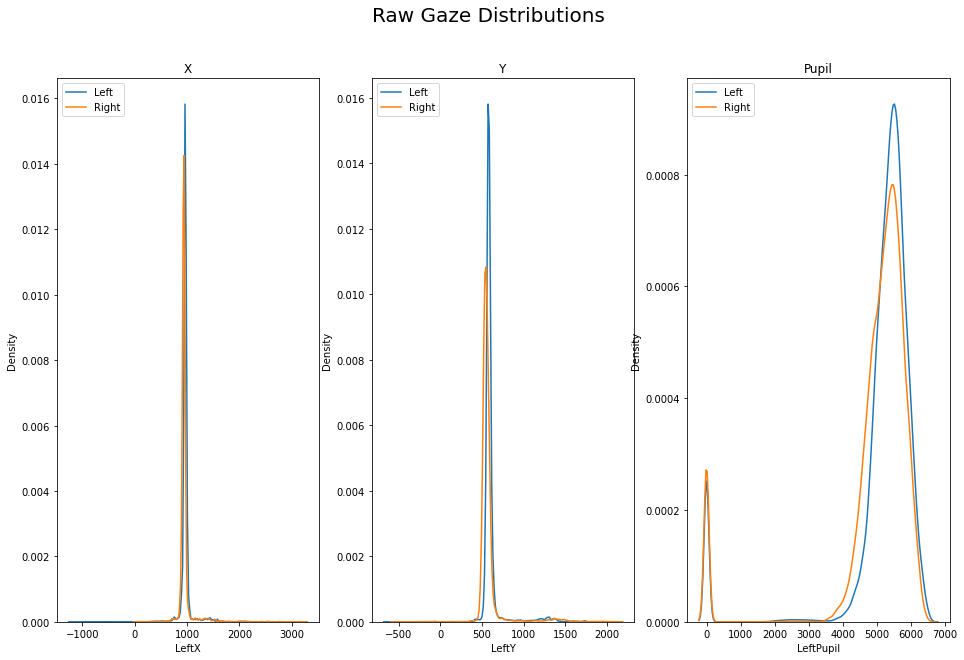

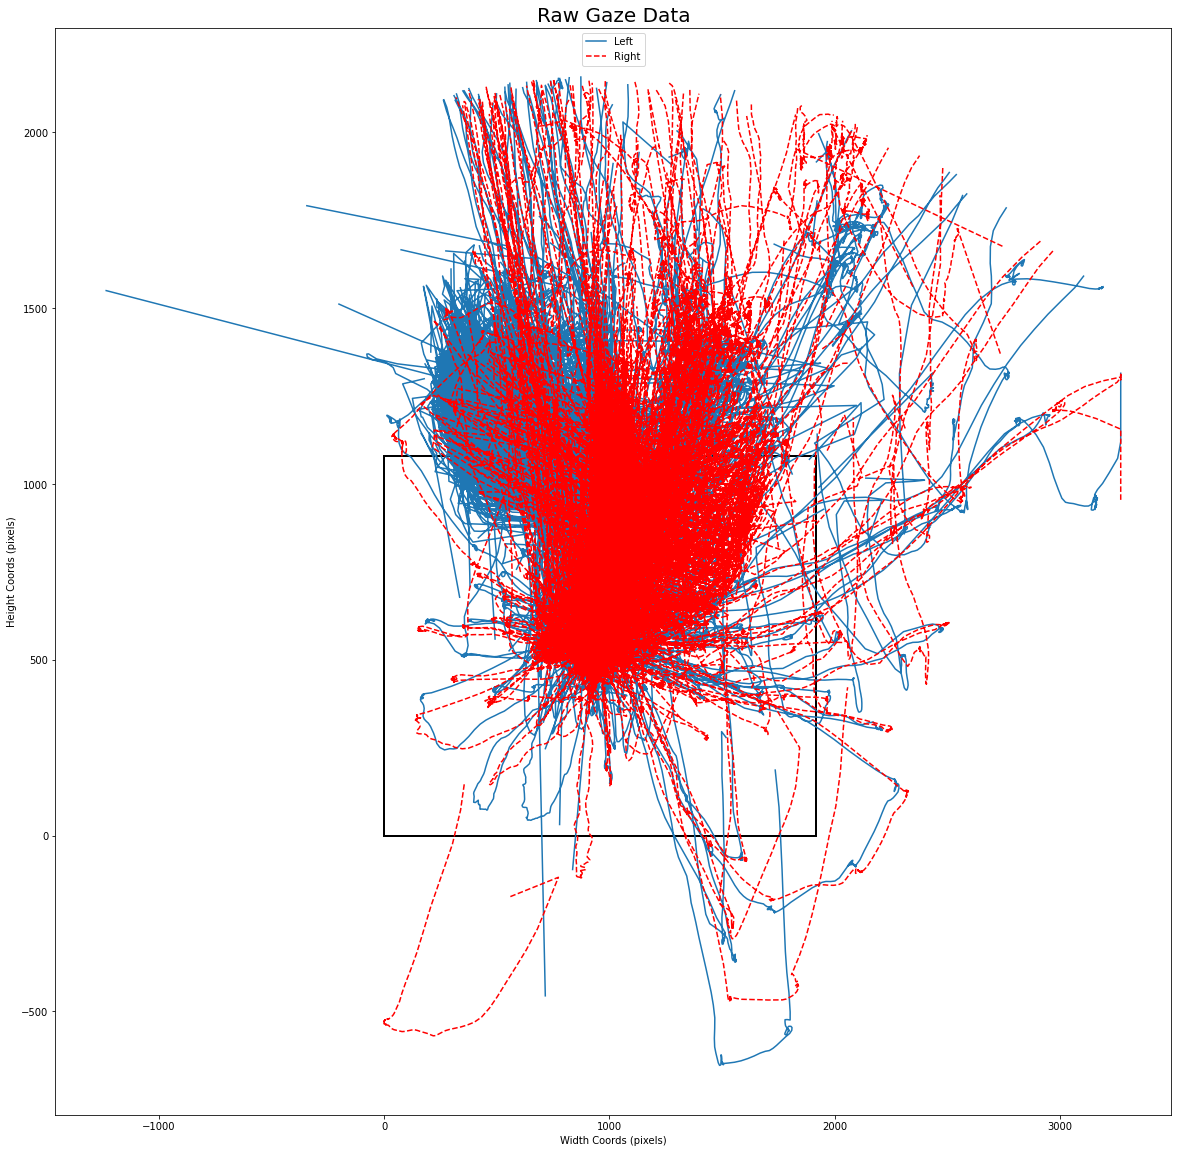

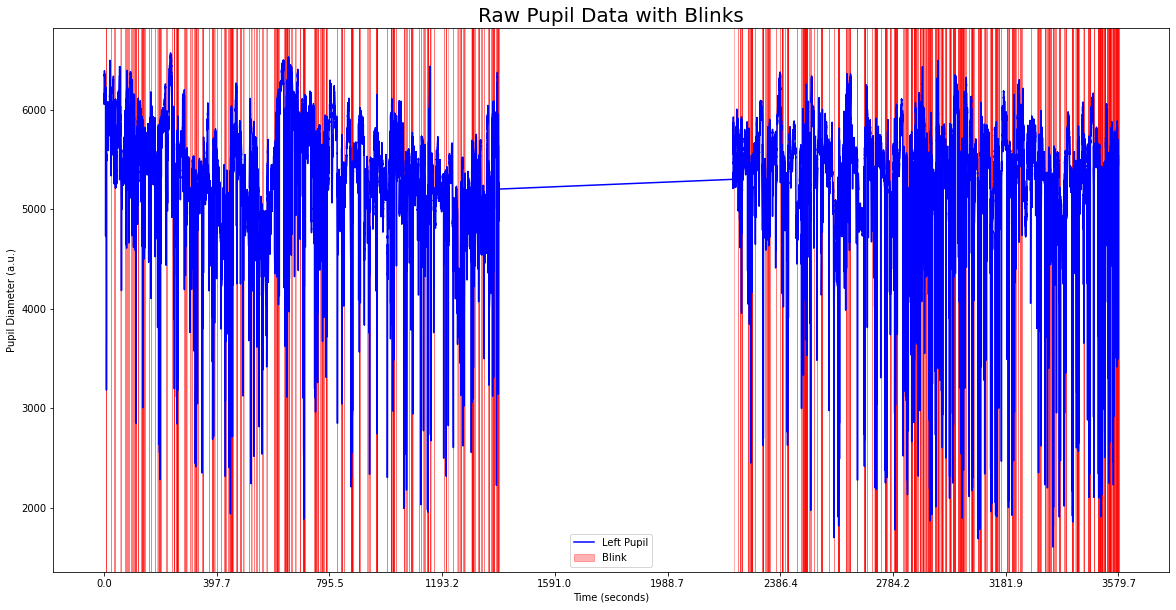

In [3]:
###  Plot Raw Data
from posttestFunctions import eyeRawKDE,plotRawGaze
import matplotlib.pyplot as plt 
log_file.write("\n===# Stats and Checks for Unfiltered Data #=== \n\n ")

#. Check whether Majority of Gaze Positions Lay in the center
print("\n(1) Check mean Gaze Center\n")
log_file.write("\n(1) Check mean Gaze Center\n")

print("                              X          Y")
log_file.write("                              X           Y\n")
print(f"Middle Screen Coordinates: {(gazeCoords[2] / 2):6.1f}      {gazeCoords[3] / 2:6.1f}")
log_file.write(f"Middle Screen Coordinates: {(gazeCoords[2] / 2):6.1f}      {gazeCoords[3] / 2:6.1f}\n")
print(f"Mean Eye Coordinates:      {np.mean(RawDF['LeftX']):5.1f}       {np.mean(RawDF['LeftY']):5.1f}")
log_file.write(f"Mean Eye Coordinates:      {np.mean(RawDF['LeftX']):5.1f}       {np.mean(RawDF['LeftY']):5.1f}\n")

# 1. Check if there are Too Many Missing data from One Eye
print("\n(2) Check Missing Pupil Data as a proxy for missing!\n")
log_file.write("\n(2) Check Missing Pupil Data as a proxy for missing!\n")
zeroPupilLeft = RawDF[RawDF['LeftPupil'] == 0]
zeroPupilRight = RawDF[RawDF['RightPupil'] == 0]
zeroPupilBoth = RawDF[(RawDF['RightPupil'] == 0) & (RawDF['LeftPupil'] == 0)]
print(f"Number of NoGaze Data: \n(Left: {len(zeroPupilLeft)}, Right: {len(zeroPupilRight)}), Both: {len(zeroPupilBoth)}")
log_file.write(f"Number of NoGaze Data: \n(Left: {len(zeroPupilLeft)}, Right: {len(zeroPupilRight)}), Both: {len(zeroPupilBoth)}\n")

log_file.write("\n"+"-"*100 + "\n")


# (1) Mismatch between Pupil Diameters Left to Right 
# Get raw when all data are greater than 0 (no blinks) 
RawDFPupilTrue = RawDF[(RawDF['LeftPupil'] > 0) & (RawDF['RightPupil'] > 0)]
pupilDifference = (RawDFPupilTrue['LeftPupil'] - RawDFPupilTrue['RightPupil']) / RawDFPupilTrue['LeftPupil']

print("\n (3) Pupil Difference Test \n")
log_file.write("\n (3) Pupil Difference Test \n")
print(f"    Percentage Difference: {np.mean(pupilDifference)}")
log_file.write(f"    Percentage Difference: {np.mean(pupilDifference)}\n")


### Plots! 
eyeRawKDE(RawDF)
plt.savefig(os.path.join(workingDir,filename,filename+"_Distribution.png"))
plotRawGaze(RawDF,gazeCoords)
plt.savefig(os.path.join(workingDir,filename,filename+"_RawGaze.png"))
plotPupilTimecourse(RawDFPupilTrue, "Raw Pupil Data with Blinks", blinkDF, saccadesDF, fixationDF, chooseViz='001')
plt.savefig(os.path.join(workingDir,filename,filename+"_RawPupil.png"))


#### New Individual Procedure:

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from posttestFunctions import (
    downsamplePupil,
    interpolate_blinks,
    plotPupilTimecourse,
    removeOutliers,
    replace_zero_clusters_with_nans,
    smooth_pupil_data,
    count_gaze_outside,
    plotEyeWithBlink,
    preprocessingPipeline
)


verbose = 1
resRate = 100
dgvCent = 5
blinkInt = 0;
maxblength = 500
blkboundry = 75
blinkbegbound = 1000
smoothwin = 10
maxcluslen = 2000
mingaplen = 500;
# Define output directory
output_dir =os.path.join(workingDir,filename)

# Define PDF paths
pdf_path_downsampled = os.path.join(output_dir, "Downsampled_Pupil_Data.pdf")
pdf_path_screen_only = os.path.join(output_dir, "Screen_Only.pdf")
pdf_path_blink_rejection = os.path.join(output_dir, "After_Pupil_Artefacts_Rejection.pdf")
pdf_path_outlier_rejection = os.path.join(output_dir, "After_Outlier_Rejection.pdf")
pdf_path_centered = os.path.join(output_dir, "CenteredPupil.pdf")
pdf_path_nan_rejection = os.path.join(output_dir,"NaN_rejected_Pupil.pdf")
# Open PdfPages objects for each PDF
pdf_downsampled = PdfPages(pdf_path_downsampled)
pdf_center_only = PdfPages(pdf_path_screen_only)
pdf_blink_rejection = PdfPages(pdf_path_blink_rejection)
pdf_outlier_rejection = PdfPages(pdf_path_outlier_rejection)

pdf_nan_rejection = PdfPages(pdf_path_nan_rejection)
pdf_smoothed = PdfPages(pdf_path_centered)
log_file.write("\n===# Preprocessing the Data #=== \n\n ")
log_file.write(f"    Preproc Parameters: General: \n")
log_file.write(f"        Verbose:              {verbose}\n")
log_file.write(f"        Resampling Rate:      {resRate}\n")
log_file.write(f"        DGV from Center:      {dgvCent}\n\n")
log_file.write(f"    Preproc Parameters: Blinks: \n")
log_file.write(f"        Blink Interpolation:  {blinkInt}\n")
log_file.write(f"        Maximum Blink Length: {maxblength}\n")
log_file.write(f"        Blink Interp Bound:   {blkboundry}\n")
log_file.write(f"        Blink Begining Bound: {blinkbegbound}\n\n")
log_file.write(f"    Preproc Parameters: Smooth: \n")
log_file.write(f"        Window size:          {smoothwin}\n")
log_file.write(f"        Minimal Cluster len:  {maxcluslen}\n")
log_file.write(f"        Maximal Gap Length:   {mingaplen}\n\n")
# Iterate through events of split_data
finalDataStruct = {}
for story, data_dict in split_data.items():
    finalDataStruct[story] = {}
    for part, RawDF in data_dict['RawDF'].items():
        print(f"\nAnalysing: {story} // {part} ")
        log_file.write(f"    ### Analysing: {story} // {part} ###\n")

        blinkDF = data_dict['blinkDF'][part]
        saccadesDF = data_dict['saccadesDF'][part]

        verbose = 1
        blinkBoundary = 50
        maxBlinkDur = 500

        finalData = preprocessingPipeline(blinkDF,RawDF,saccadesDF,gazeCoords,story,part,log_file=log_file,pdfs=[pdf_downsampled,pdf_center_only,pdf_blink_rejection ,pdf_outlier_rejection ,pdf_nan_rejection,pdf_smoothed],
                                          verbose=verbose,interp_type=blinkInt,interpBoundary=blkboundry,maxBlinkDur=maxblength,resampleRate=resRate,dgvCenter=dgvCent,smoothwin=smoothwin,
                                          min_cluster_duration=maxcluslen,max_gap_duration=mingaplen)
        log_file.write("\n        Final Data Stats: \n")
        log_file.write(finalData.describe().to_string().replace('\n', '\n\t\t').join(['\t\t', ''])) # Adds two Tabulations!
        log_file.write("\n\n")
        log_file.write("        Sanity Checks on Final Data: \n")
        log_file.write(f"            Number of Non-missing Data events: {len(finalData['LeftPupil'].dropna())} ({len(finalData['LeftPupil'].dropna())/len(finalData)} %)\n")

        finalDataStruct[story][part] = finalData;

# Close PdfPages objects
pdf_downsampled.close()
pdf_center_only.close()
pdf_blink_rejection.close()
pdf_outlier_rejection.close()
pdf_smoothed.close()
pdf_nan_rejection.close()
log_file.close()
print("Processing complete. PDFs saved.")


Analysing: STORY_1 // KASIA_1 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:6133.0

Analysing: STORY_1 // JANEK_1 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:5956.0

Analysing: STORY_1 // KASIA_2 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:5669.0

Analysing: STORY_1 // JANEK_2 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:5994.0

Analysing: STORY_1 // KASIA_3 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:6517.0

Analysing: STORY_1 // JANEK_3 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by

In [5]:
import pickle
import os

# Save the data structure to a file in the working directory
output_path = os.path.join(workingDir,filename, filename+'_prep.pkl')
with open(output_path, 'wb') as file: 
    pickle.dump(finalDataStruct, file)

In [6]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

def interactive_pupil_plot(ScreenData, blinks, saccades, fixations, gazeCoords, window_size=2000, chooseViz='011'):
    """
    Create an optimized interactive plot with a slider to explore pupil diameter and raw gaze points.

    Parameters:
    ScreenData (DataFrame): Screen data containing time points, pupil diameter, and gaze coordinates.
    blinks (DataFrame): DataFrame containing blink events.
    saccades (DataFrame): DataFrame containing saccade events.
    fixations (DataFrame): DataFrame containing fixation events.
    gazeCoords (list): Screen dimensions [x_min, y_min, width, height].
    window_size (int): Size of the sliding window in milliseconds.
    chooseViz (str): String of bools indicating which visualizations to include (fixations, saccades, blinks).
    """
    # Downsample ScreenData for better performance
    downsample_factor = max(1, len(ScreenData) // 5000)  # Keep at most 5000 points
    ScreenData = ScreenData.iloc[::downsample_factor]

    # Initialize the figure and axes
    fig = plt.figure(figsize=(20, 8))  # Adjust figure size for better layout
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)  # Create a grid with 2 columns

    # Main plot: Pupil diameter time course
    ax_main = fig.add_subplot(gs[0, 0])  # Left plot
    ax_main.set_title("Pupil Diameter Time Course", fontsize=16)
    ax_main.set_xlabel("Time (seconds)")
    ax_main.set_ylabel("Pupil Diameter (a.u.)")
    ax_main.plot(ScreenData['TimePoint'], ScreenData['LeftPupil'], label="Left Pupil", color='blue')

    # Add fixation, saccade, and blink rectangles
    if bool(int(chooseViz[0])):
        for _, fixation in fixations.iterrows():
            ax_main.axvspan(fixation['Beg'], fixation['End'], color='lightblue', alpha=0.2, label="Fixation" if _ == 0 else "")
    if bool(int(chooseViz[1])):
        for _, saccade in saccades.iterrows():
            ax_main.axvspan(saccade['Beg'], saccade['End'], color='green', alpha=0.3, label="Saccade" if _ == 0 else "")
    if bool(int(chooseViz[2])):
        for _, blink in blinks.iterrows():
            ax_main.axvspan(blink['Beg'], blink['End'], color='red', alpha=0.3, label="Blink" if _ == 0 else "")

    # Add a rectangle to indicate the current window
    window_rect = ax_main.axvspan(ScreenData['TimePoint'].iloc[0], ScreenData['TimePoint'].iloc[0] + window_size, color='orange', alpha=0.3, label="Window")

    # Secondary plot: Raw gaze points
    ax_gaze = fig.add_subplot(gs[0, 1])  # Right plot
    ax_gaze.set_title("Raw Gaze Points in Selected Window", fontsize=16)
    ax_gaze.set_xlabel("X Coordinate (pixels)")
    ax_gaze.set_ylabel("Y Coordinate (pixels)")

    # Set axis limits to 3x the screen size, with the screen centered
    x_center = gazeCoords[2] / 2
    y_center = gazeCoords[3] / 2
    ax_gaze.set_xlim(-gazeCoords[2], 2 * gazeCoords[2])
    ax_gaze.set_ylim(-gazeCoords[3], 2 * gazeCoords[3])

    # Maintain the correct aspect ratio
    ax_gaze.set_aspect(gazeCoords[2] / gazeCoords[3])

    # Add a rectangle representing the screen dimensions
    rect = plt.Rectangle((0, 0), gazeCoords[2], gazeCoords[3], linewidth=2, edgecolor='black', facecolor='none')
    ax_gaze.add_patch(rect)

    # Scatter plot for gaze points
    gaze_scatter = ax_gaze.scatter([], [], color='blue', label="Left Eye Gaze")

    # Add a slider for the time window
    ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03], facecolor='none')  # Slider below the plots
    slider = Slider(ax_slider, "Time (ms)", ScreenData['TimePoint'].iloc[0], ScreenData['TimePoint'].iloc[-1] - window_size, valinit=ScreenData['TimePoint'].iloc[0])

    # Update function for the slider
    def update(val):
        start_time = slider.val
        end_time = start_time + window_size

        # Update the rectangle in the main plot
        window_rect.set_xy([[start_time, 0], [start_time, 1], [end_time, 1], [end_time, 0]])

        # Filter ScreenData for the selected window
        window_data = ScreenData[(ScreenData['TimePoint'] >= start_time) & (ScreenData['TimePoint'] <= end_time)]

        # Update the gaze scatter plot
        gaze_scatter.set_offsets(np.c_[window_data['LeftX'], window_data['LeftY']])

        # Redraw the figure
        fig.canvas.draw_idle()

    # Connect the slider to the update function
    slider.on_changed(update)

    # Add legends and show the plot
    ax_main.legend()
    ax_gaze.legend()
    plt.show()

In [7]:
%matplotlib qt

blinkDF = split_data['STORY_2']['blinkDF']['ADAM_9']
RawDF = split_data['STORY_2']['RawDF']['ADAM_9']
RawDFDown = downsamplePupil(RawDF,logfile=log_file,divisor=500/100)

interactive_pupil_plot(
    ScreenData=RawDFDown,
    blinks=blinkDF,
    saccades=saccadesDF,
    fixations=fixationDF,
    gazeCoords=[0,0,1920, 1080],  # Example screen dimensions
    window_size=1000,  # 2-second window
    chooseViz='001'  # Show fixations, saccades, and blinks
)

    Downsampling to rate 100.0


ValueError: I/O operation on closed file.

In [ ]:

verbose = 2
blinkBoundary = 50
maxBlinkDur = 500

blinkDF = split_data['STORY_2']['blinkDF']['ADAM_9']
RawDF = split_data['STORY_2']['RawDF']['ADAM_9']
saccadesDF = split_data['STORY_2']['saccadesDF']['ADAM_9']




    Removing Points from Outside of the Gaze by 5 dg. 
Blink Removed: 0, Duration: 362.0
    Warning - Either there are no Clusters in data


## Propoer Analysis

In [ ]:
#### Proper Analysis

# Get the data for the first story for all events: 

def getMeanPupil(split_data, event_dfs,story_name,Eye):
    """ From LEft Eue"""
    meanPupilMW = []
    meanPupilMB =[]
    meanPupilFOCUS = []
    meanPupilTUT = []
    for event_name, RawDF in split_data[story_name]['RawDF'].items():
        blinkDF = split_data[story_name]['blinkDF'][event_name]
        saccadesDF = split_data[story_name]['saccadesDF'][event_name]

        finalData = preprocessingPipeline(blinkDF,RawDF,saccadesDF[saccadesDF['Eye'] == 'L'],gazeCoords,story_name,event_name,log_file=None,pdfs=[],verbose=0)

        ### Compute mean of last 10s of the data
        meanPupil = finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - 10000)][Eye].std()
        if event_dfs[event_dfs["Part"] == event_name]['key'].values[0] == "MW":
            meanPupilMW.append(meanPupil)
        elif event_dfs[event_dfs["Part"] == event_name]['key'].values[0]== "MB":
            meanPupilMB.append(meanPupil)
        elif event_dfs[event_dfs["Part"] == event_name]['key'].values[0] == "FOCUS":
            meanPupilFOCUS.append(meanPupil)
        elif event_dfs[event_dfs["Part"] == event_name]['key'].values[0] == "TRT":
            meanPupilTUT.append(meanPupil)


    return meanPupilMW, meanPupilMB, meanPupilFOCUS, meanPupilTUT


[ meanPupilMW, meanPupilMB, meanPupilFOCUS, meanPupilTUT] = getMeanPupil(split_data, event_dfs,'STORY_1','LeftPupil')




Blink Removed: 0, Duration: 178.0
Blink Removed: 23, Duration: 160.0
Blink Removed: 0, Duration: 262.0
Blink Removed: 0, Duration: 180.0
Blink Removed: 0, Duration: 362.0
Blink Removed: 1, Duration: 148.0
Blink Removed: 0, Duration: 700.0
Blink Removed: 0, Duration: 190.0
Blink Removed: 0, Duration: 100.0
Blink Removed: 1, Duration: 162.0
Blink Removed: 25, Duration: 198.0
Blink Removed: 0, Duration: 184.0
Blink Removed: 21, Duration: 148.0
Blink Removed: 0, Duration: 140.0
Blink Removed: 2, Duration: 766.0
Blink Removed: 0, Duration: 868.0
Blink Removed: 0, Duration: 138.0
Blink Removed: 1, Duration: 190.0
Blink Removed: 22, Duration: 254.0
Blink Removed: 0, Duration: 242.0
Blink Removed: 23, Duration: 178.0
Blink Removed: 0, Duration: 162.0
Blink Removed: 1, Duration: 246.0
Blink Removed: 0, Duration: 550.0
Blink Removed: 1, Duration: 184.0
Blink Removed: 0, Duration: 162.0
Blink Removed: 0, Duration: 514.0
Blink Removed: 0, Duration: 194.0
Blink Removed: 25, Duration: 180.0
Blink Re

In [ ]:
#### Stats of Introspecitve Probes: 
log_file = open(os.path.join(workingDir,filename,filename+"_analysisLog.txt"),'w+')

log_file.write(" "*15+"="*58 + "\n")
log_file.write(" "*15+"="*5+ " "*15+" PREPROC LOG FILE"+ " "*15+"="*5+ " \n")
log_file.write(" "*15+"="*58 + "\n\n")
log_file.write("\n===# General Info: #=== \n\n")

MBevents = event_dfs[event_dfs["key"] == 'MB']
TRTevents = event_dfs[event_dfs["key"] == 'TRT']
FOCUSevents = event_dfs[event_dfs["key"] == 'FOCUS']
MWevents = event_dfs[event_dfs["key"] == 'MW']

log_file.write( "\n                 Pupil Std Stats:\n")
log_file.write( "\n                N:    Mean:    Std: \n")
log_file.write(f"     MW       {len(MWevents):4.1f}    {np.mean(meanPupilMW):4.1f}    {np.std(meanPupilMW):4.1f}\n")
log_file.write(f"     FOCUS    {len(FOCUSevents):4.1f}    {np.mean(meanPupilFOCUS):4.1f}    {np.std(meanPupilFOCUS):4.1f}\n")
log_file.write(f"     TRT      {len(TRTevents):4.1f}    {np.mean(meanPupilTUT):4.1f}    {np.std(meanPupilTUT):4.1f}\n")
log_file.write(f"     MB       {len(MBevents):4.1f}    {np.mean(meanPupilMB):4.1f}    {np.std(meanPupilMB):4.1f}\n")


print( "                 Pupil Std Stats:")
print( "                N:    Mean:    Std: ")
print(f"     MW       {len(MWevents):4.1f}    {np.mean(meanPupilMW):4.1f}    {np.std(meanPupilMW):4.1f}")
print(f"     FOCUS    {len(FOCUSevents):4.1f}    {np.mean(meanPupilFOCUS):4.1f}    {np.std(meanPupilFOCUS):4.1f}")
print(f"     TRT      {len(TRTevents):4.1f}    {np.mean(meanPupilTUT):4.1f}    {np.std(meanPupilTUT):4.1f}")
print(f"     MB       {len(MBevents):4.1f}    {np.mean(meanPupilMB):4.1f}    {np.std(meanPupilMB):4.1f}")

log_file.close()

                 Pupil Std Stats:
                N:    Mean:    Std: 
     MW        2.0    380.3     0.0
     FOCUS    26.0    301.2    91.4
     TRT      16.0    306.7    76.3
     MB        0.0     nan     nan


C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value enco

,beg,end,keytime
count,4.400000e+01,4.400000e+01,4.400000e+01
mean,2.045883e+06,2.105687e+06,2.107962e+06
std,1.457130e+06,1.456601e+06,1.456672e+06
min,1.160000e+02,6.143900e+04,6.569800e+04
25%,6.788725e+05,7.415155e+05,7.431022e+05
50%,2.048563e+06,2.107579e+06,2.110059e+06
75%,3.419564e+06,3.478465e+06,3.481546e+06
max,4.081365e+06,4.140232e+06,4.142164e+06
